## minimdo version of Aircraft sizing

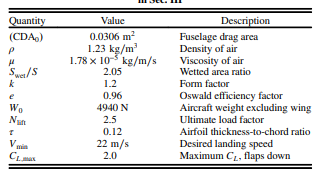 

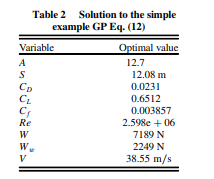

In [1]:
from modeling.couplingapi import Subproblem, intersection
from modeling.couplingapi import problem, get_vals
from modeling.compute import Par, Var
from openmdao.api import n2
import numpy as np
from modeling.execution import edges_from_components
from solver.runpipeline import run_valid_formulation
from graph.matrixview import render_incidence
from graph.graphutils import VAR, COMP, SOLVER

In [2]:
A = Var('A') # aspect ratio (unitless)
V = Var('V', unit='m/s')
S = Var('S', unit='m^2')
W = Var('W')

Aero = Subproblem()
rho = Par('rho', 1.23, 'kg/m^3')
mu = Par('mu', 1.78e-5, 'kg/m/s')
k = Par('k', 1.2)
t = Par('t', 0.12, 'm')
e = Par('e', 0.96)
CDA = Par('CDA', 0.0306, 'm^2')
SwetS = Par('SwetS', 2.05)
CL = Aero.Var('C_L', 2*W/(rho*V**2*S))
Re = Aero.Var('Re', rho*V/mu*(S/A)**(1/2))
Cf = Aero.Var('C_f', 0.074/Re**0.2, unit='', forceunit=True)
CD = Aero.Var('C_D', CDA/S+k*Cf*SwetS+CL**2/(np.pi*A*e), unit='', forceunit=True)
D = Aero.Var('D', 0.5*rho*V**2*CD*S)

Struct = Subproblem()
W0 = Par('W0', 4940, 'N')
N = Par('N', 2.5)
rhoS = Par('rhoS', 45.42, 'N/m^2')
Ww = Struct.Var('W_w', rhoS*S+8.71e-5*N/t*A**(3/2)*S**(1/2)*(W0*W)**(1/2), unit='N', forceunit=True)
Struct.add_equation(W, W0+Ww)

W

In [3]:
sol1 = {A:18.16, S: 5.255, V: 49.18, W:7083.65}
sol2 = {A:18.9, S: 5.6, V: 48.28, W:7338.34}
Aero.solve(sol1), Struct.solve(sol1)

({C_L: array(0.90621701),
  Re: array(1828108.93636204),
  C_f: array(0.00413839),
  C_D: array(0.03099781),
  D: array(242.30135766)},
 {W_w: array(2142.95446938), W: array(7082.95446938)})

In [4]:
Struct.solve({A: 12.1, S: 14.15, V: 57.11, W: 7311})

{W_w: array(2369.26645434), W: array(7309.26645434)}

In [5]:
AeroStruct = intersection(Struct, Aero, mergesets=False)

In [6]:
AeroStruct.solve(sol1)

{W_w: array(2142.95446938),
 W: array(7082.95446938),
 C_L: array(0.90612803),
 Re: array(1828108.93636204),
 C_f: array(0.00413839),
 C_D: array(0.03099486),
 D: array(242.27834217)}

In [7]:
P = problem(D, [], [Aero, Struct], flatten=True)

In [8]:
from modeling.execution import edges_from_components
from solver.runpipeline import run_valid_formulation
from graph.matrixview import render_incidence
from graph.graphutils import VAR, COMP, SOLVER

In [9]:
#P = AeroStruct
edges = edges_from_components(P.components)
tree = P.Ftree, P.Stree, {'A': 2, 'S':2, 'V':2} # <- this needs to be fixed

In [10]:
tree

(OrderedDict([(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2)]),
 {},
 {'A': 2, 'S': 2, 'V': 2})

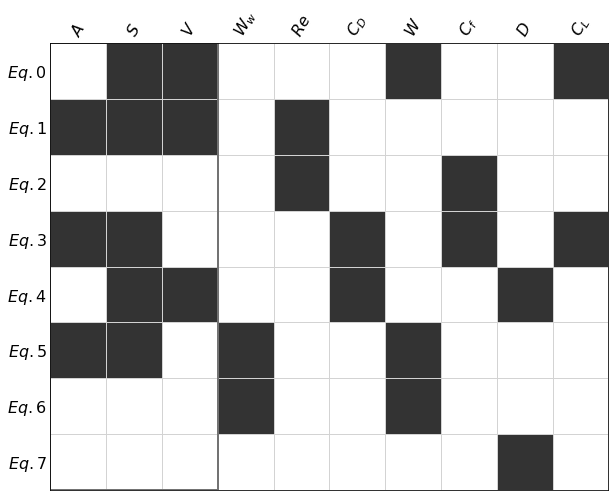

In [11]:
from collections import namedtuple
from itertools import chain
from modeling.api import edges_no_param
Model = namedtuple('Model', 'idmapping')
render_incidence(edges_no_param(Model({str(v): v for v in chain(P.projected, P.independent)}), edges), tree, rawvarname=True, figsize=(10, 10), diagonalgray=False, hideticks=True);

In [12]:
solver_options = P.solver_options
#solver_options.update({AeroStruct.id: {'solver':'GS', 'maxiter': 30}})

#solver_options.update({2: {'solver':'GS'}})
#solver_options.update({0: {'solver':'GS', 'maxiter': 30}})

#solver_options[P.id].update({'tol': 1e-6})
comp_options = P.comp_options
var_options = {}

In [13]:
comp_options

{0: EQ, 1: EQ, 2: EQ, 3: EQ, 4: EQ, 5: EQ, 6: EQ, 7: OBJ}

In [14]:
nametyperepr = {VAR: '{}', COMP: 'f{}', SOLVER: 's{}'}
prob, mdao_in, groups = run_valid_formulation(edges, tree, P.components, solver_options, comp_options, var_options, nametyperepr)

In [17]:
P.prob = prob
solve_point = {A:18, S: 5, V: 49, W:7000}
solve_point.update({
    Ww: 2000,
    CL: 0.9,
    Re: 2e6,
    Cf: 0.004,
    CD: 0.02,
    D: 300})
sol3 = P.solve_with_engine(solve_point, optimize=True)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: [300.]
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


c:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1567: DerivativesWarning:Constraints or objectives [('f7.obj7', inds=[0]), ('f2.eq2', inds=[0]), ('f6.eq6', inds=[0])] cannot be impacted by the design variables of the problem.


In [65]:
sol3

{W_w: array([2168.67237179]),
 W: array([7108.67237179]),
 C_L: array([0.90540212]),
 Re: array([1829543.97543398]),
 C_f: array([0.00413774]),
 C_D: array([0.03085827]),
 D: array([242.28056461])}

In [17]:
sol3 = {**solve_point, **sol3}

In [19]:
Struct.solve(sol3)

{W_w: array(1189.50800267), W: array(6129.50800267)}

In [51]:
prob.list_problem_vars()

----------------
Design Variables
----------------
name  val            size  
----  -------------  ---- 
A     [18.16227017]  1     
S     [5.25558686]   1     
V     [49.17925456]  1     

-----------
Constraints
-----------
name  val  size  
----  ---  ---- 

----------
Objectives
----------
name  val             size  
----  --------------  ---- 
obj7  [242.27476297]  1     



In [14]:
from graph.graphutils import flat_graph_formulation, VAR, COMP, SOLVER, draw_graph_graphical_props

In [25]:
nodetyperepr = {VAR: '{}', COMP: '{}', SOLVER: 'P_{}'}
G = flat_graph_formulation(*edges_nopar, nodetyperepr=nodetyperepr)

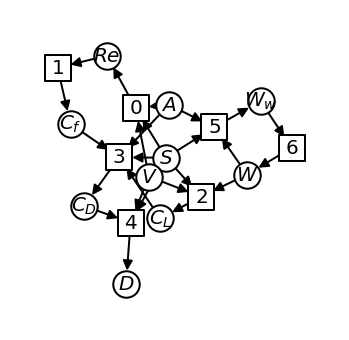

In [26]:
draw_graph_graphical_props(G, prog='neato', figsize=(6,6));

In [3]:
eq_list = [f1,f2,f3,f4,f5,f6,f7]
eqs = idx_eqlist(eq_list)
eqv = eqvars(eqs)
dins = default_in(eqs, count_never_output=True) #includes parameters
dout = default_out(eqs)

In [4]:
eqv_noparams = {elt:{key for key in keys if not key.never_output} for elt,keys in eqv.items()}

In [5]:
DG, edges = digraph_repr(eqv_noparams, dout, intermediary=False)

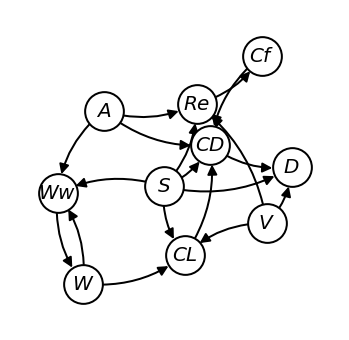

In [9]:
draw(DG, node_shape='o', node_size=1500, arc=0.2)

In [7]:
order = mdf_order(eqv, dout)

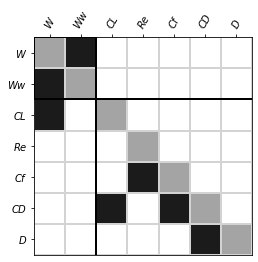

In [13]:
ax = draw_dsm(DG, flatten_order(order), dout)
rect1 = patches.Rectangle((0, 0), 2, 2, linewidth=2, edgecolor='k', facecolor='none')
#rect1.set_alpha(0.2)
rect2 = patches.Rectangle((2, 2), 7, 7, linewidth=2, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2);
plt.savefig('woodymdf.png', dpi=600)

In [4]:
eq_list

[(Re, V*rho*(S/A)**0.5/mu),
 (Cf, 0.074*Re**(-0.2)),
 (CD, CDA/S + Cf*SwetS*k + 0.318309886183791*CL**2/(A*e)),
 (D, 0.5*CD*S*V**2*rho),
 (Ww, 8.71e-5*A**1.5*N*S**0.5*(W*W0)**0.5/t + S*rhoS),
 (W, W0 + Ww),
 (CL, 2*W/(S*V**2*rho))]

In [6]:
order

[(4, 5), 6, 0, 1, 2, 3]

In [7]:
dins

{A, CDA, N, S, SwetS, V, W0, e, k, mu, rho, rhoS, t}

In [18]:
prob = om.Problem()
model = prob.model
# buildidpvars(dins | {W, Ww} , model)
# counter = coupled_run(eqs, [6, 0, 1, 2, 3], (5,4), model, model, useresiduals=True)
buildidpvars(dins, model)
counter = coupled_run(eqs, order, (), model, model)
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
# prob.model.add_design_var('W', lower=1e3, upper=1e4)
# prob.model.add_design_var('Ww', lower=1e3, upper=1e4)
#prob.model.add_subsystem('dummy', om.ExecComp('obj = 0'))
prob.model.add_design_var('A', lower=0.1, upper=50)
prob.model.add_design_var('V', lower=0.1, upper=50)
prob.model.add_design_var('S', lower=0.1, upper=50)
prob.model.add_objective('D')
#prob.model.add_objective('dummy.obj')
prob.setup()
prob.set_solver_print(level=0)
prob.set_val('A', 12)
prob.set_val('V', 40)
prob.set_val('S', 12)
prob.run_driver();
#prob.run_model()

Optimization terminated successfully    (Exit mode 0)
            Current function value: [242.27476039]
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10
Optimization Complete
-----------------------------------


In [29]:
prob.model.group1.group2.eq5.iter_count

34

In [19]:
model.list_outputs();

20 Explicit Output(s) in 'model'

varname   val               
--------  ------------------
inp
  S       [5.25550216]      
  k       [1.2]             
  CDA     [0.0306]          
  rhoS    [45.42]           
  V       [49.18282355]     
  rho     [1.23]            
  N       [2.5]             
  e       [0.96]            
  W0      [4940.]           
  A       [18.1632583]      
  SwetS   [2.05]            
  t       [0.12]            
  mu      [1.78e-05]        
group1
  group2
    eq4
      Ww  [2143.57006145]   
    eq5
      W   [7083.57006145]   
  eq6
    CL    [0.90601616]      
  eq0
    Re    [1828137.24540357]
  eq1
    Cf    [0.00413838]      
  eq2
    CD    [0.03098788]      
  eq3
    D     [242.27476039]    


0 Implicit Output(s) in 'model'




In [15]:
model.list_outputs();

23 Explicit Output(s) in 'model'

varname   val               
--------  ------------------
inp
  t       [0.12]            
  V       [40.]             
  rho     [1.23]            
  N       [2.5]             
  k       [1.2]             
  e       [0.96]            
  W       [7024.26985372]   
  rhoS    [45.42]           
  Ww      [2084.26985372]   
  mu      [1.78e-05]        
  SwetS   [2.05]            
  CDA     [0.0306]          
  S       [12.]             
  W0      [4940.]           
  A       [12.]             
group1
  group2
    eq6
      CL  [0.5948738]       
    eq0
      Re  [2764044.94382023]
    eq1
      Cf  [0.00380998]      
    eq2
      CD  [0.02170049]      
    eq3
      D   [256.23938743]    
eq5
  r5      [4.54747351e-13]  
eq4
  r4      [4.54747351e-13]  
dummy
  obj     [0.]              


0 Implicit Output(s) in 'model'




In [14]:
model.list_outputs();

20 Explicit Output(s) in 'model'

varname   val               
--------  ------------------
inp
  rhoS    [45.42]           
  rho     [1.23]            
  e       [0.96]            
  S       [12.]             
  t       [0.12]            
  k       [1.2]             
  A       [12.]             
  CDA     [0.0306]          
  SwetS   [2.05]            
  N       [2.5]             
  mu      [1.78e-05]        
  V       [40.]             
  W0      [4940.]           
group1
  group2
    eq5
      W   [7024.26985372]   
    eq4
      Ww  [2084.26985372]   
  eq6
    CL    [0.5948738]       
  eq0
    Re    [2764044.94382023]
  eq1
    Cf    [0.00380998]      
  eq2
    CD    [0.02170049]      
  eq3
    D     [256.23938743]    


0 Implicit Output(s) in 'model'




In [165]:
outs = get_outputs(eqs, model)

In [166]:
outs

{mu: 1.78e-05,
 Ww: 2143.6524106356314,
 W: 7083.652410635632,
 rho: 1.23,
 CL: 0.9060217147255142,
 Cf: 0.004138390950999994,
 D: 242.2747605249787,
 k: 1.2,
 Re: 1828104.5087784836,
 S: 5.2552958763529665,
 A: 18.164008601092604,
 SwetS: 2.05,
 CDA: 0.0306,
 t: 0.12,
 N: 2.5,
 V: 49.18392392118704,
 rhoS: 45.42,
 e: 0.96,
 CD: 0.030987713857328826,
 W0: 4940.0}

In [75]:
check_eqs(eqs, outs)

{0: (1828166.6351383294, 1828166.63513833),
 1: (0.004138362823732449, 0.00413836282373245),
 2: (0.03098730227757834, 0.0309873022775783),
 3: (242.2747603987664, 242.274760398766),
 4: (2143.537966630028, 2143.53796663003),
 5: (7083.537966630029, 7083.53796663003),
 6: (0.905995043831173, 0.905995043831173)}